## Predicting the Probability of Loan Eligibility with Binary Logistic Regression

#### Data Analysis Project by Zeeho (Jenny) Lee

In [83]:
library(tidyverse)
library(gridExtra)
library(leaps)
library(car)
library(broom)

### Introduction

The loan eligibility determination process could be automated by building a prediction model based on the information of applicants, including the marital status, number of dependents, income, co-applicant's income, loan amount, and credit history. Creating a classifier would not only allow a more rapid and convenient determination process but would also help customers check their competitiveness for receiving loans. This project aims to use Logistic Regression to predict the probability of being eligible for loans by considering the customers' information. 

Both the training and the testing data files have been downloaded from [Loan Eligible Dataset](https://www.kaggle.com/datasets/vikasukani/loan-eligible-dataset?resource=download) webpage in Kaggle and moved to the personal cloud storage.

### Exploratory Data Analysis

The datasets will be read directly from the web into R. The observations that miss data for any variables will be omitted.

In [84]:
test_url <- "https://drive.google.com/uc?export=download&id=1lKzOZT_Hjp0dGIr5pqWD8MXcVAWqMyJh"

train_url <- "https://drive.google.com/uc?export=download&id=1JxgV24bpKgfx9Nl0i0G5ZDR7LyDKHmeI"

test <- read.csv(test_url) |> 
            na.omit() |>
            filter(Gender %in% c("Male", "Female")) |>
            filter(Married %in% c("Yes", "No")) |>
            filter(Self_Employed %in% c("Yes", "No")) |>
            filter(Dependents %in% c("0", "1", "2", "3+"))

train <- read.csv(train_url) |> 
            na.omit() |>
            filter(Gender %in% c("Male", "Female")) |>
            filter(Married %in% c("Yes", "No")) |>
            filter(Self_Employed %in% c("Yes", "No")) |>
            filter(Dependents %in% c("0", "1", "2", "3+"))

head(train)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y


Each observation represents a customer who applied for a loan. There are 13 variables in the training dataset, and `Loan_Status` is the response variable.

| Variable Name                 | Description                                    |
|-------------------------------|------------------------------------------------|
| `Loan_ID`                     | a unique loan ID assigned to each application  |
| `Gender`                      | the gender of the applicant (Male/Female)  |
| `Married`                     | the marital status of the applicant (Yes/No) |
| `Dependents`                  | the number of dependents of the applicant     |
| `Education`                   | the level of education of the applicant (Graduate/Not Graduate (no Graduate Degree))    |
| `Self_Employed`               | the self-employment status of the applicant (Yes/No)        |
| `ApplicantIncome`             | the monthly income of the applicant |
| `CoapplicantIncome`           | the monthly income of the coapplicant      |
| `LoanAmount`                  | the loan amount (in $1000)  |
| `Loan_Amount_Term`            | the term of a loan (in months)       |
| `Credit_History`              | the credit history status (1 if the applicant's credit history meets the guideline, 0 if it does not)   |
| `Property_Area`               | the location of the applicant's property (Rural/Urban/Semi-Urban)     |
| `Loan_Status`                 | the approval status of the loan (Y (Yes)/N (No))      |

The distributions of the variables will be visualized through histograms, bar graphs, and pie charts.

Gender,n,prop
<chr>,<int>,<dbl>
Female,86,0.1791667
Male,394,0.8208333


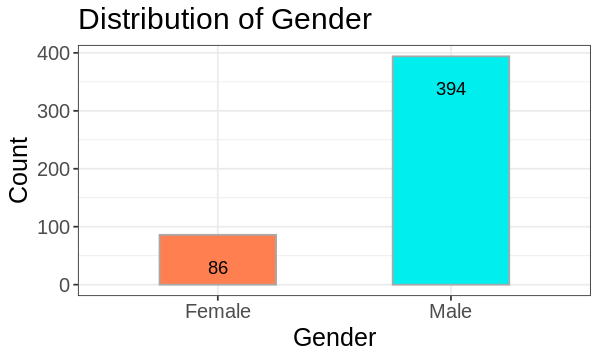

In [85]:
options(repr.plot.width = 5, repr.plot.height = 3)

gender_plot <- train |>
    ggplot(aes(x = Gender)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Gender",
         y = "Count",
         title = "Distribution of Gender") +
    theme_bw() +
    theme(text = element_text(size = 15))
gender_plot

train |>
    count(Gender) |>
    mutate(prop = n / nrow(train))

Married,n,prop
<chr>,<int>,<dbl>
No,169,0.3520833
Yes,311,0.6479167


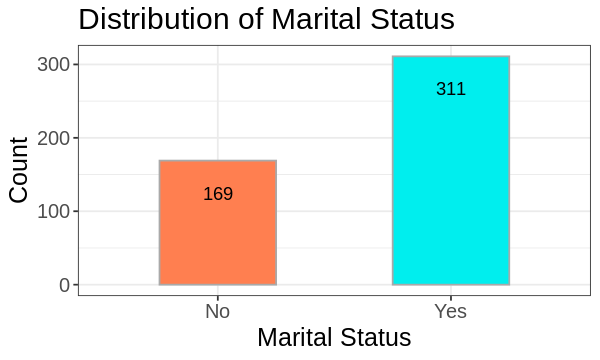

In [86]:
options(repr.plot.width = 5, repr.plot.height = 3)

married_plot <- train |>
    ggplot(aes(x = Married)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Marital Status",
         y = "Count",
         title = "Distribution of Marital Status") +
    theme_bw() +
    theme(text = element_text(size = 15))
married_plot

train |>
    count(Married) |>
    mutate(prop = n / nrow(train))

Education,n,prop
<chr>,<int>,<dbl>
Graduate,383,0.7979167
Not Graduate,97,0.2020833


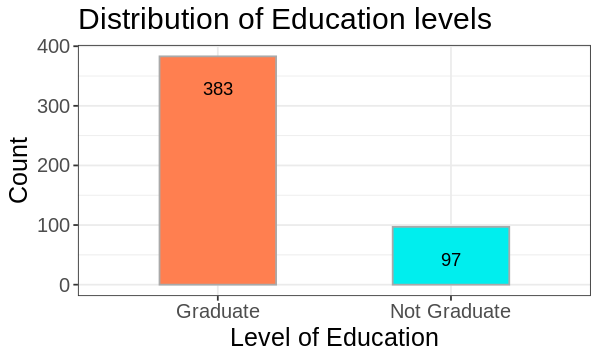

In [87]:
options(repr.plot.width = 5, repr.plot.height = 3)

education_plot <- train |>
    ggplot(aes(x = Education)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Level of Education",
         y = "Count",
         title = "Distribution of Education levels") +
    theme_bw() +
    theme(text = element_text(size = 15))
education_plot

train |>
    count(Education) |>
    mutate(prop = n / nrow(train))

Self_Employed,n,prop
<chr>,<int>,<dbl>
No,414,0.8625
Yes,66,0.1375


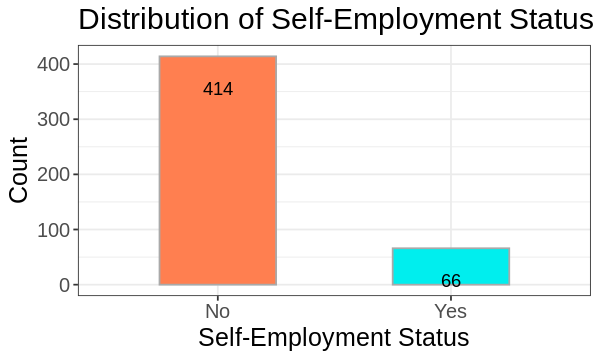

In [88]:
options(repr.plot.width = 5, repr.plot.height = 3)

employed_plot <- train |>
    ggplot(aes(x = Self_Employed)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Self-Employment Status",
         y = "Count",
         title = "Distribution of Self-Employment Status") +
    theme_bw() +
    theme(text = element_text(size = 15))
employed_plot

train |>
    count(Self_Employed) |>
    mutate(prop = n / nrow(train))

mean,sd,median,IQR
<dbl>,<dbl>,<dbl>,<dbl>
5364.231,5668.251,3859,2953.75


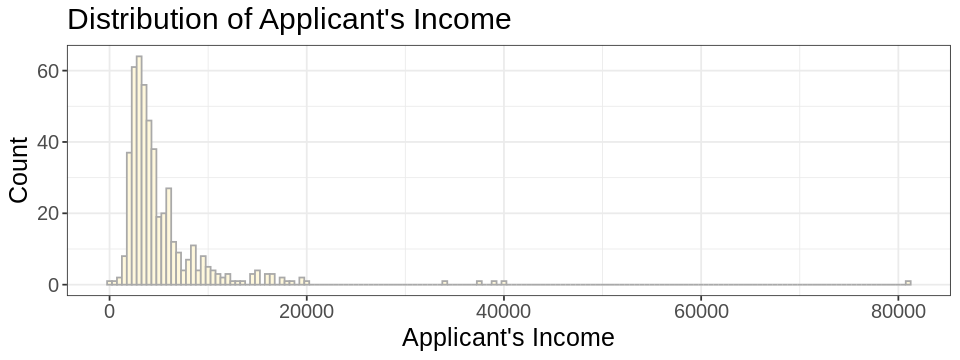

In [89]:
options(repr.plot.width = 8, repr.plot.height = 3)

income_plot <- train |>
    ggplot(aes(x = ApplicantIncome)) +
    geom_histogram(bins = 10, color = "darkgrey", fill = "cornsilk", binwidth = 500) +
    labs(x = "Applicant's Income",
         y = "Count",
         title = "Distribution of Applicant's Income") +
    theme_bw() +
    theme(text = element_text(size = 15))
income_plot

train |>
    summarize(mean = mean(ApplicantIncome),
              sd = sd(ApplicantIncome),
              median = median(ApplicantIncome),
              IQR = IQR(ApplicantIncome))

mean,sd,median,IQR
<dbl>,<dbl>,<dbl>,<dbl>
1581.094,2617.692,1084.5,2253.25


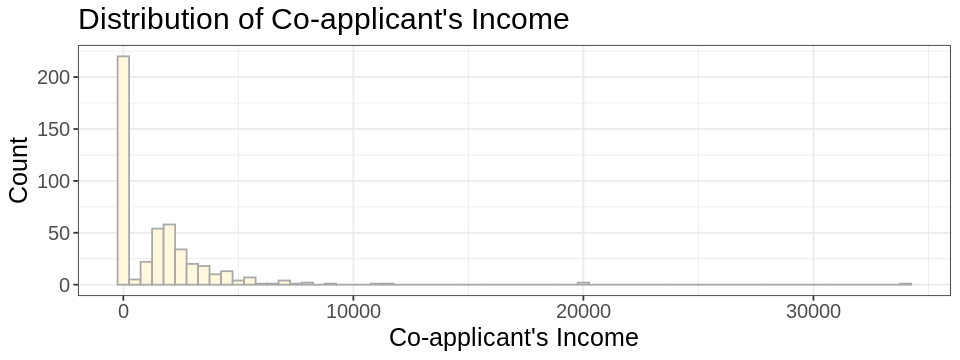

In [90]:
options(repr.plot.width = 8, repr.plot.height = 3)

co_income_plot <- train |>
    ggplot(aes(x = CoapplicantIncome)) +
    geom_histogram(bins = 10, color = "darkgrey", fill = "cornsilk", binwidth = 500) +
    labs(x = "Co-applicant's Income",
         y = "Count",
         title = "Distribution of Co-applicant's Income") +
    theme_bw() +
    theme(text = element_text(size = 15))
co_income_plot

train |>
    summarize(mean = mean(CoapplicantIncome),
              sd = sd(CoapplicantIncome),
              median = median(CoapplicantIncome),
              IQR = IQR(CoapplicantIncome))

mean,sd,median,IQR
<dbl>,<dbl>,<dbl>,<dbl>
144.7354,80.50816,128,70


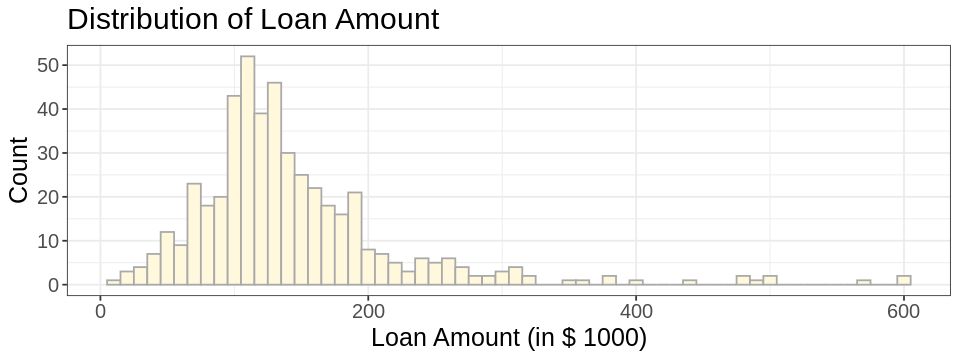

In [91]:
options(repr.plot.width = 8, repr.plot.height = 3)

amount_plot <- train |>
    ggplot(aes(x = LoanAmount)) +
    geom_histogram(bins = 10, color = "darkgrey", fill = "cornsilk", binwidth = 10) +
    labs(x = "Loan Amount (in $ 1000)",
         y = "Count",
         title = "Distribution of Loan Amount") +
    theme_bw() +
    theme(text = element_text(size = 15))
amount_plot

train |>
    summarize(mean = mean(LoanAmount),
              sd = sd(LoanAmount),
              median = median(LoanAmount),
              IQR = IQR(LoanAmount))

mean,sd,median,IQR
<dbl>,<dbl>,<dbl>,<dbl>
342.05,65.2124,360,0


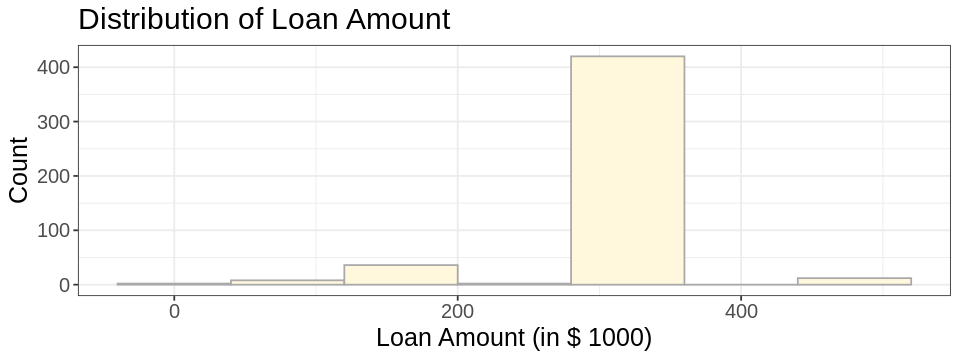

In [92]:
options(repr.plot.width = 8, repr.plot.height = 3)

term_plot <- train |>
    ggplot(aes(x = Loan_Amount_Term)) +
    geom_histogram(bins = 10, color = "darkgrey", fill = "cornsilk", binwidth = 80) +
    labs(x = "Loan Amount (in $ 1000)",
         y = "Count",
         title = "Distribution of Loan Amount") +
    theme_bw() +
    theme(text = element_text(size = 15))
term_plot

train |>
    summarize(mean = mean(Loan_Amount_Term),
              sd = sd(Loan_Amount_Term),
              median = median(Loan_Amount_Term),
              IQR = IQR(Loan_Amount_Term))

Credit_History,n,prop
<int>,<int>,<dbl>
0,70,0.1458333
1,410,0.8541667


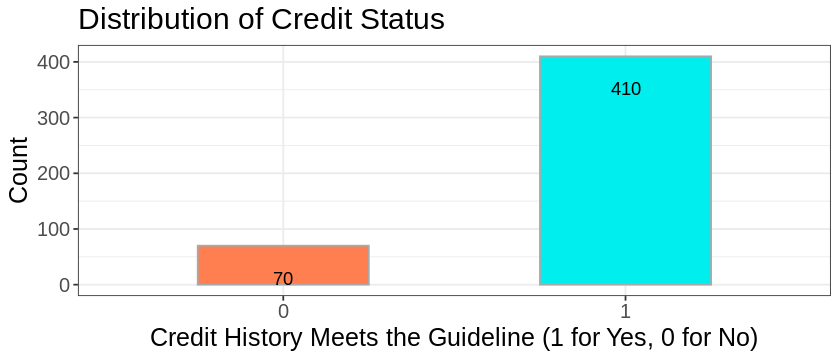

In [93]:
options(repr.plot.width = 7, repr.plot.height = 3)

credit_plot <- train |>
    mutate_at(vars(Credit_History), factor) |>
    ggplot(aes(x = Credit_History)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Credit History Meets the Guideline (1 for Yes, 0 for No)",
         y = "Count",
         title = "Distribution of Credit Status") +
    theme_bw() +
    theme(text = element_text(size = 15))
credit_plot

train |>
    count(Credit_History) |>
    mutate(prop = n / nrow(train))

Property_Area,n,prop
<chr>,<int>,<dbl>
Rural,139,0.2895833
Semiurban,191,0.3979167
Urban,150,0.3125000


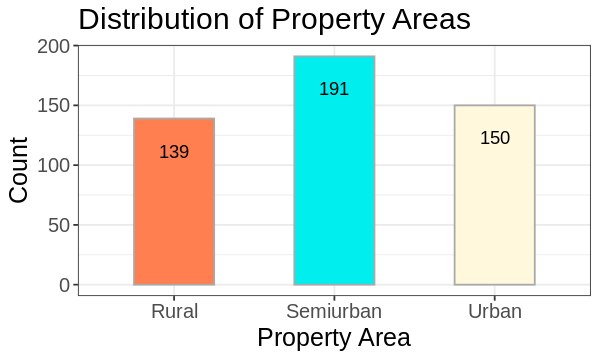

In [94]:
options(repr.plot.width = 5, repr.plot.height = 3)

credit_plot <- train |>
    ggplot(aes(x = Property_Area)) +
    geom_bar(width = 0.5, color = "darkgrey", fill = c("coral", "cyan2", "cornsilk")) +
    geom_text(stat = "count", aes(label = after_stat(count)), vjust = 3) +
    labs(x = "Property Area",
         y = "Count",
         title = "Distribution of Property Areas") +
    theme_bw() +
    theme(text = element_text(size = 15))
credit_plot

train |>
    count(Property_Area) |>
    mutate(prop = n / nrow(train))

Loan_Status,n,prop
<chr>,<int>,<dbl>
N,148,0.3083333
Y,332,0.6916667


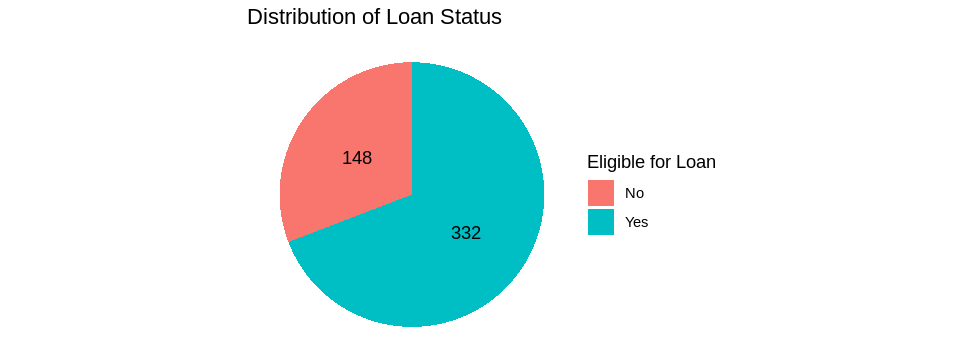

In [95]:
options(repr.plot.width = 8, repr.plot.height = 3)

loan <- train |> 
        count(Loan_Status)

df <- data.frame(
  group = c("No", "Yes"),
  value = loan[,2]
  )

credit_plot <- df |>
    ggplot(aes(x = "", y = value, fill = group)) +
    geom_col() +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    theme_void() +
    labs(title = "Distribution of Loan Status") +
    guides(fill = guide_legend(title = "Eligible for Loan")) +
    geom_text(aes(label = value), position = position_stack(vjust = 0.5)) 
credit_plot

train |>
    count(Loan_Status) |>
    mutate(prop = n / nrow(train))

### Binary Logistic Regression Analysis

Let there be a binary response that represents the approval status of the loan, with 1 being "Approved" and 0 being "Rejected".

In [96]:
train_data <- 
    train |> 
    mutate(Loan_Status = if_else(Loan_Status == "Y", 1, 0))

head(train_data)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,1
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1,Urban,1
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,1


For the estimation of a binary logistic regression, the argument `family = binomial` can be applied to the function `glm()`. The covariates that are used in the model are: the applicant's gender, marital status, number of dependents, education levels, self-employment status, income, co-applicant's income, loan amount, length of term, credit history, and property area. The response variable is the applicant's eligibility for the loan. Applying the argument `exponentiate = TRUE` in the function `tidy()` can produce the summary of the model with the exponentiated coefficients and the adjusted standard errors.

In [97]:
Loan_model <- 
    glm(formula = Loan_Status ~ Gender + Married + Dependents + Education + Self_Employed + ApplicantIncome + CoapplicantIncome + LoanAmount + Loan_Amount_Term + Credit_History + Property_Area,
        data = train_data,
        family = binomial)

tidy(Loan_model, exponentiate = TRUE) |> 
    mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.088,0.931,-2.609,0.009
GenderMale,1.385,0.331,0.983,0.325
MarriedYes,1.775,0.292,1.963,0.050
Dependents1,0.687,0.346,-1.085,0.278
Dependents2,1.319,0.378,0.733,0.464
Dependents3+,1.207,0.487,0.386,0.699
EducationNot Graduate,0.656,0.303,-1.388,0.165
Self_EmployedYes,0.861,0.352,-0.423,0.672
ApplicantIncome,1.000,0.000,0.243,0.808


According to the summary of the model:

* Ceteris paribus, since the estimated exponentiated coefficient of `GenderMale` is `1.385`, the odds of loan eligibility are 38.5% higher for male applicants compared to female applicants.
* Ceteris paribus, since the estimated exponentiated coefficient of `MarriedYes` is `1.775`, the odds of loan eligibility are 77.5% higher for married applicants compared to singles.
* Compared to having 0 dependents, the odds of loan eligibility are 31.9% higher for applicants with 2 dependents, and 20.7% higher for those with 3 or more dependents. On the other hand, since the estimated exponentiated coefficient of `Dependents1` is `0.687` and 1/0.687 = 1.456, the odds of not being eligible for the loan is 45.6% higher for applicants with 1 dependents compared to those who have no dependents.
* Ceteris paribus, since the estimated exponentiated coefficient of `EducationNot Graduate` is `0.656` and 1/0.656 = 1.524, the odds of not being eligibile for the loan are 52.4% higher for applicants who have no graduate degrees compared to those who have them.
* Ceteris paribus, since the estimated exponentiated coefficient of `Self_EmployedYes` is `0.861` and 1/0.861 = 1.161, the odds of not being eligibile for the loan are 16.1% higher for applicants who are self-employed compared to those who are not.
* Ceteris paribus, since the estimated exponentiated coefficient of `ApplicantIncome` is `1.000`, $1000 increase in the applicant's income is related to 0% increase in the odds of their eligibility for the loan. Considering that the exponentiated coefficients for `CoapplicantIncome`, `LoanAmount`, and `Loan_Amount_Term` are `1.000`, `0.997`, and `0.997`, respectively, these variables may not be the major factors that determine the eligibility for the loans.

The estimated exponentiated coefficients for `Credit_History` and `Property_Area` are significantly high. The contigency tables for each of these variables and the loan approval status are shown below. Note that 1 represents being approved (eligible for the loan), and 0 represents being disapproved. 

In [98]:
table(train_data$Loan_Status, train_data$Credit_History)

   
      0   1
  0  63  85
  1   7 325

As shown in the table, the probability of being approved for receiving loan when the applicant has credit history which does not meet the guideline is 57.4%, since 85/(63+85) = 0.574. On the other hand, if the applicant's credit history meets the guideline, the probability of being approved for receiving loan is 97.9%, since 325/(7+325) = 0.979. Hence, it appears that there is a significant association between credit history and loan eligibility.

In [99]:
table(train_data$Loan_Status, train_data$Property_Area)

   
    Rural Semiurban Urban
  0    54        42    52
  1    85       149    98

The probability of being approved for receiving loan when the applicant's property is located in rural, semiurban, and urban areas are 61.2%, 78.0%, and 65.3%, respectively. Based on these values, it may be deemed doubtful if the location of an applicant's property has a significant influence on their loan eligibility.

### Prediction

The loan approval probability can be predicted for the testing data based on the logistic regression model constructed above. To predict the probability of the binary response variable, the argument `type = "response"` can be applied to the function `predict()`.

In [100]:
Prediction <- 
    predict(Loan_model,
            newdata = test,
            type = "response")

head(Prediction)

1         2         3         4         5         6 
0.8424249 0.7615996 0.8302891 0.6796347 0.6879595 0.7174864

The `cbind()` function can be used to combine the testing dataset the prediction results.

In [101]:
test_prob <- cbind(test, Prediction)

head(test_prob)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Prediction
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>
1,LP001015,Male,Yes,0,Graduate,No,5720,0,110,360,1,Urban,0.8424249
2,LP001022,Male,Yes,1,Graduate,No,3076,1500,126,360,1,Urban,0.7615996
3,LP001031,Male,Yes,2,Graduate,No,5000,1800,208,360,1,Urban,0.8302891
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78,360,1,Urban,0.6796347
5,LP001054,Male,Yes,0,Not Graduate,Yes,2165,3422,152,360,1,Urban,0.6879595
6,LP001055,Female,No,1,Not Graduate,No,2226,0,59,360,1,Semiurban,0.7174864


The prediction model has been constructed to automate the decision process, but further study is required to assess the accuracy of the predictions. However, to conduct this study, it is necessary to have the response variable in the testing dataset. The original datasets found in the Kaggle lack information on the loan approval status for observations in the testing set. Hence, in the future study, it may be essential to divide the original training dataset into two groups to construct a prediction model and test its accuracy.

The application of data science could be extended to other parts of industry. Although this model has been designed to be used at financial institutions for a more convenient loan approval process, it could be modified for various purposes. Future projects may focus on constructing classifiers with datasets other than customer information.

### Dataset

Ukani, V. (2020). Loan Eligible Dataset, Version 1. Retrieved October 10, 2023 from https://www.kaggle.com/datasets/vikasukani/loan-eligible-dataset/data.